In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00


In [4]:
import json
import pandas as pd
import re
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_linear_schedule_with_warmup, get_scheduler
import torch
from torch.optim import AdamW
from tqdm import tqdm
from evaluate import load as load_metric

# Import datasets.

In [18]:
# Loading data.
train_path = '/content/drive/My Drive/Colab Notebooks/General Model/train.jsonl'
val_path = '/content/drive/My Drive/Colab Notebooks/General Model/val.jsonl'
test_path = '/content/drive/My Drive/Colab Notebooks/General Model/test.jsonl'

def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_jsonl(train_path)
val_data = load_jsonl(val_path)
test_data = load_jsonl(test_path)

# Checking the data.
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 3200
Validation samples: 400
Test samples: 400


In [19]:
# Check the distribution of tags.
tag_counter = Counter([item["tags"][0] for item in train_data])
print(tag_counter)
tag_counter = Counter([item["tags"][0] for item in val_data])
print(tag_counter)

Counter({'phrase': 1367, 'passage': 1274, 'multi': 559})
Counter({'phrase': 162, 'passage': 154, 'multi': 84})


In [20]:
# Replace the postId column name with uuid to align the preprocessing function.
for example in val_data:
    example['uuid'] = example.pop('postId')

In [21]:
# Check missing value.
def check_missing(data, split_name="train"):
    keys_to_check = ['postText', 'targetTitle', 'targetParagraphs', 'tags', 'spoiler']
    missing_summary = defaultdict(int)

    for i, example in enumerate(data):
        for key in keys_to_check:
            if key not in example:
                missing_summary[f"missing_key_{key}"] += 1
            elif example[key] is None or (isinstance(example[key], list) and len(example[key]) == 0) or (isinstance(example[key], str) and example[key].strip() == ""):
                missing_summary[f"empty_{key}"] += 1
            elif key == 'spoiler' and isinstance(example[key], list) and (len(example[key]) == 0 or example[key][0].strip() == ""):
                missing_summary["empty_spoiler_text"] += 1

    if missing_summary:
        print(f"⚠️  {split_name} ：")
        for issue, count in missing_summary.items():
            print(f"- {issue}: {count}")
    else:
        print(f"✅ {split_name} No missing or null values were found in the data.")

check_missing(train_data, "train")
check_missing(val_data, "val")

⚠️  train ：
- empty_targetTitle: 1
⚠️  val ：
- empty_targetTitle: 1


# pre-processing data.

In [22]:
# Extract the first 7 sentences and the last 5 sentences of target paragraph.
def prepare_input_no_tag(example, max_length=450):
    post = example['postText'][0]
    title = example['targetTitle']
    paragraphs = example['targetParagraphs']
    full_text = " ".join(paragraphs)
    sentences = re.split(r'(?<=[.?!])\s+', full_text)
    selected = sentences[:7] + sentences[-5:]
    content = " ".join(selected)[:max_length]
    input_text = f"Post: {post}\nTitle: {title}\nContent: {content}"
    return input_text

def prepare_data(raw_data, split='train', use_tag=False):
    data_list = []
    for example in raw_data:
        input_text = prepare_input_no_tag(example)
        target_text = example['spoiler'][0] if split != 'test' else ""
        data_list.append({
            "uuid": example['uuid'],
            "input_text": input_text,
            "target_text": target_text
        })
    return data_list

In [23]:
# PyTorch Dataset for spoiler generation, tokenizes input-target pairs for seq2seq models like T5.
class SpoilerDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_input_len=512, max_target_len=64):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      item = self.data[idx]

      input_enc = self.tokenizer(
          item['input_text'],
          padding='max_length',
          truncation=True,
          max_length=self.max_input_len,
          return_tensors='pt')

      target_enc = self.tokenizer(
          item['target_text'],
          padding='max_length',
          truncation=True,
          max_length=self.max_target_len,
          return_tensors='pt')

      labels = target_enc.input_ids.squeeze()
      labels[labels == self.tokenizer.pad_token_id] = -100

      return {
          "input_ids": input_enc.input_ids.squeeze(),
          "attention_mask": input_enc.attention_mask.squeeze(),
          "labels": labels
      }

In [24]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

In [25]:
# Pre-prossessing dataset.
train_data_list = prepare_data(train_data, split='train')
val_data_list = prepare_data(val_data, split='val')

train_dataset = SpoilerDataset(train_data_list, tokenizer)
val_dataset = SpoilerDataset(val_data_list, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Training process.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
!pip install rouge_score

In [30]:
# Set up training configuration.
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 10

train_losses = []
val_losses = []
rouge_scores = []

rouge = load_metric("rouge")
best_val_loss = float('inf')
patience = 1
patience_counter = 0


===== Epoch 1/10 =====


Training: 100%|██████████| 400/400 [07:23<00:00,  1.11s/it]


✅ Train Loss: 2.2951


Validating: 100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


🧪 Val Loss: 2.0111
📊 ROUGE-L: 0.3614
💾 New best model saved (ROUGE-L = 0.3614)

===== Epoch 2/10 =====


Training: 100%|██████████| 400/400 [07:17<00:00,  1.09s/it]


✅ Train Loss: 1.9678


Validating: 100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


🧪 Val Loss: 1.9946
📊 ROUGE-L: 0.3749
💾 New best model saved (ROUGE-L = 0.3749)

===== Epoch 3/10 =====


Training: 100%|██████████| 400/400 [07:17<00:00,  1.09s/it]


✅ Train Loss: 1.7108


Validating: 100%|██████████| 50/50 [01:45<00:00,  2.10s/it]


🧪 Val Loss: 2.0193
📊 ROUGE-L: 0.3858
💾 New best model saved (ROUGE-L = 0.3858)
😴 No improvement. Patience = 1/1
🛑 Early stopping triggered.


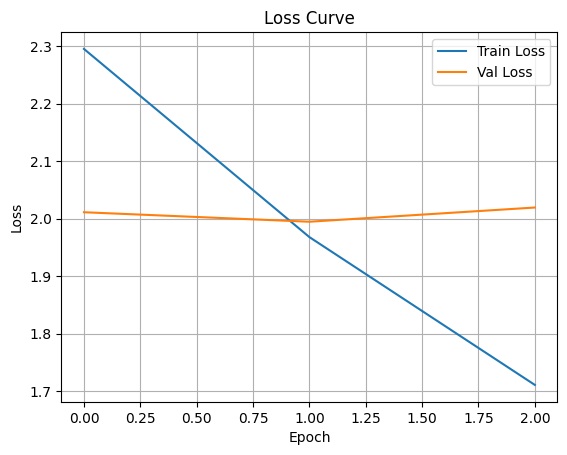

In [ ]:
best_rouge = 0.0
save_path = "/content/drive/MyDrive/Colab Notebooks/General Model/best_model.pt"

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # Train.
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"✅ Train Loss: {avg_train_loss:.4f}")

    # Validation.
    model.eval()
    total_val_loss = 0.0
    generated_texts = []
    reference_texts = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)

            total_val_loss += outputs.loss.item()

            generated = model.generate(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       max_length=32,
                                       length_penalty=0.8,
                                       num_beams=5)

            labels_clean = labels.clone()
            labels_clean[labels_clean == -100] = tokenizer.pad_token_id

            decoded_preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels_clean, skip_special_tokens=True)

            generated_texts.extend(decoded_preds)
            reference_texts.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"🧪 Val Loss: {avg_val_loss:.4f}")

    rouge_result = rouge.compute(predictions=generated_texts,
                                 references=reference_texts,
                                 use_stemmer=True)
    rouge_score = rouge_result["rougeL"]
    rouge_scores.append(rouge_score)
    print(f"📊 ROUGE-L: {rouge_score:.4f}")

    # Save best model based on ROUGE-L.
    if rouge_score > best_rouge:
        best_rouge = rouge_score
        torch.save(model.state_dict(), save_path)
        print(f"💾 New best model saved (ROUGE-L = {rouge_score:.4f})")

    # Early stopping based on val loss.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"😴 No improvement. Patience = {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

# Plot Loss Curve.
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# testset spoiler generation

In [32]:
# Load the best performance model.
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/General Model/best_model.pt"))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [33]:
# Replace the id column name with uuid to align the preprocessing function.
for example in test_data:
    example['uuid'] = example.pop('id')

In [34]:
# Prepare test set data.
test_data_list = prepare_data(test_data, split='test')

# Generate test set results.
model.eval()
test_results = []

for example in tqdm(test_data_list, desc="Generating Test Results"):
    input_text = example["input_text"]

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512)

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=32,
            num_beams=5,
            length_penalty=0.6)

    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    test_results.append({
        "id": example["uuid"],
        "spoiler": prediction})

Generating Test Results: 100%|██████████| 400/400 [03:23<00:00,  1.97it/s]


In [35]:
# Save the results.
output_path = "/content/drive/My Drive/Colab Notebooks/prediction_task2.csv"
df = pd.DataFrame(test_results)
df.to_csv(output_path, index=False)

print("Already saved：", output_path)

Already saved： /content/drive/My Drive/Colab Notebooks/prediction_task2.csv
